In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Unsupervised Learning: Dimensionality Reduction and Clustering

**Unsupervised Learning** addresses a different sort of problem. Here the data has no labels,
and we are interested in finding similarities between the objects in question. In a sense,
you can think of unsupervised learning as a means of discovering labels from the data itself.
Unsupervised learning comprises tasks such as *dimensionality reduction*, *clustering*, and
*density estimation*. For example, in the iris data discussed above, we can used unsupervised
methods to determine combinations of the measurements which best display the structure of the
data. As we'll see below, such a projection of the data can be used to visualize the
four-dimensional dataset in two dimensions. Some more involved unsupervised learning problems are:

- given detailed observations of distant galaxies, determine which features or combinations of
  features best summarize the information.
- given a mixture of two sound sources (for example, a person talking over some music),
  separate the two (this is called the [blind source separation](http://en.wikipedia.org/wiki/Blind_signal_separation) problem).
- given a video, isolate a moving object and categorize in relation to other moving objects which have been seen.

Sometimes the two may even be combined: e.g. Unsupervised learning can be used to find useful
features in heterogeneous data, and then these features can be used within a supervised
framework.

### Dimensionality Reduction: PCA

Principle Component Analysis (PCA) is a dimension reduction technique that can find the combinations of variables that explain the most variance.

Consider the iris dataset. It cannot be visualized in a single 2D plot, as it has 4 features. We are going to extract 2 combinations of sepal and petal dimensions to visualize it:

In [3]:
from sklearn import datasets
iris = datasets.load_iris()
X, y = iris.data, iris.target

from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(X)
X_reduced = pca.transform(X)
print("Reduced dataset shape:", X_reduced.shape)

Reduced dataset shape: (150, 2)


Meaning of the 2 components:
0.362 x sepal length (cm) + -0.082 x sepal width (cm) + 0.857 x petal length (cm) + 0.359 x petal width (cm)
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.176 x petal length (cm) + -0.075 x petal width (cm)


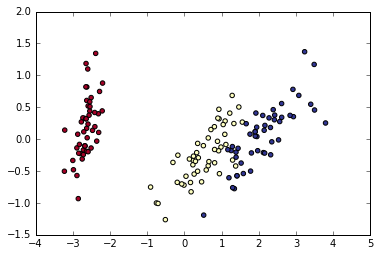

In [4]:
import pylab as plt
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='RdYlBu')

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component, iris.feature_names)))

#### Clustering: K-means

Clustering groups together observations that are homogeneous with respect to a given criterion, finding ''clusters'' in the data.

Note that these clusters will uncover relevent hidden structure of the data only if the criterion used highlights it.

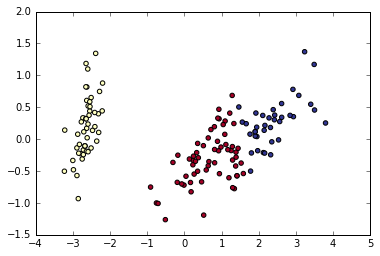

In [6]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, random_state=0) # Fixing the RNG in kmeans
k_means.fit(X)
y_pred = k_means.predict(X)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred, cmap='RdYlBu');

### Recap: Scikit-learn's estimator interface

Scikit-learn strives to have a uniform interface across all methods,
and we'll see examples of these below. Given a scikit-learn *estimator*
object named `model`, the following methods are available:

- Available in **all Estimators**
  + `model.fit()` : fit training data. For supervised learning applications,
    this accepts two arguments: the data `X` and the labels `y` (e.g. `model.fit(X, y)`).
    For unsupervised learning applications, this accepts only a single argument,
    the data `X` (e.g. `model.fit(X)`).
- Available in **supervised estimators**
  + `model.predict()` : given a trained model, predict the label of a new set of data.
    This method accepts one argument, the new data `X_new` (e.g. `model.predict(X_new)`),
    and returns the learned label for each object in the array.
  + `model.predict_proba()` : For classification problems, some estimators also provide
    this method, which returns the probability that a new observation has each categorical label.
    In this case, the label with the highest probability is returned by `model.predict()`.
  + `model.score()` : for classification or regression problems, most (all?) estimators implement
    a score method.  Scores are between 0 and 1, with a larger score indicating a better fit.
- Available in **unsupervised estimators**
  + `model.predict()` : predict labels in clustering algorithms.
  + `model.transform()` : given an unsupervised model, transform new data into the new basis.
    This also accepts one argument `X_new`, and returns the new representation of the data based
    on the unsupervised model.
  + `model.fit_transform()` : some estimators implement this method,
    which more efficiently performs a fit and a transform on the same input data.

## Model Validation

An important piece of machine learning is **model validation**: that is, determining how well your model will generalize from the training data to future unlabeled data. Let's look at an example using the *nearest neighbor classifier*. This is a very simple classifier: it simply stores all training data, and for any unknown quantity, simply returns the label of the closest training point.

With the iris data, it very easily returns the correct prediction for each of the input points:

In [7]:
from sklearn.neighbors import KNeighborsClassifier
X, y = iris.data, iris.target
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)
y_pred = clf.predict(X)
np.all(y == y_pred)

True

A more useful way to look at the results is to view the **confusion matrix**, or the matrix showing the frequency of inputs and outputs:

In [8]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y, y_pred))

[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


For each class, all 50 training samples are correctly identified. But this **does not mean that our model is perfect!** In particular, such a model generalizes extremely poorly to new data. We can simulate this by splitting our data into a *training set* and a *testing set*. Scikit-learn contains some convenient routines to do this:

In [10]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print(confusion_matrix(ytest, ypred))

[[10  0  0]
 [ 0 13  1]
 [ 0  2 12]]


This paints a better picture of the true performance of our classifier: apparently there is some confusion between the second and third species, which we might anticipate given what we've seen of the data above.

This is why it's **extremely important** to use a train/test split when evaluating your models.

## Quick Application: Optical Character Recognition

To demonstrate the above principles on a more interesting problem, let's consider OCR (Optical Character Recognition) – that is, recognizing hand-written digits.
In the wild, this problem involves both locating and identifying characters in an image. Here we'll take a shortcut and use scikit-learn's set of pre-formatted digits, which is built-in to the library.

### Loading and visualizing the digits data

We'll use scikit-learn's data access interface and take a look at this data:

In [6]:
from sklearn import datasets
digits = datasets.load_digits()
digits.images.shape

(1797, 8, 8)

Let's plot a few of these:

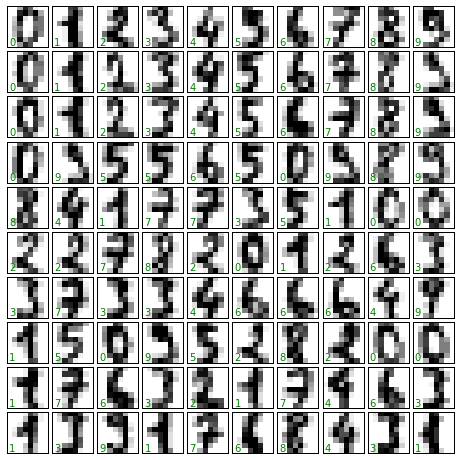

In [7]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]), transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

Here the data is simply each pixel value within an 8x8 grid:

In [8]:
# The images themselves
print(digits.images.shape)
print(digits.images[0])

(1797, 8, 8)
[[  0.   0.   5.  13.   9.   1.   0.   0.]
 [  0.   0.  13.  15.  10.  15.   5.   0.]
 [  0.   3.  15.   2.   0.  11.   8.   0.]
 [  0.   4.  12.   0.   0.   8.   8.   0.]
 [  0.   5.   8.   0.   0.   9.   8.   0.]
 [  0.   4.  11.   0.   1.  12.   7.   0.]
 [  0.   2.  14.   5.  10.  12.   0.   0.]
 [  0.   0.   6.  13.  10.   0.   0.   0.]]


In [14]:
# The data for use in our algorithms
print(digits.data.shape)
print(digits.data[0])

(1797, 64)
[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.   5.
   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.   0.   8.
   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.  11.   0.   1.
  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.   0.   0.   6.  13.
  10.   0.   0.   0.]


In [9]:
# The target label
print(digits.target)

[0 1 2 ..., 8 9 8]


So our data have 1797 samples in 64 dimensions.

### Unsupervised Learning: Dimensionality Reduction

We'd like to visualize our points within the 64-dimensional parameter space, but it's difficult to plot points in 64 dimensions!
Instead we'll reduce the dimensions to 2, using an unsupervised method.
Here, we'll make use of a manifold learning algorithm called *Isomap*, and transform the data to two dimensions.

In [10]:
from sklearn.manifold import Isomap

In [11]:
iso = Isomap(n_components=2)
data_projected = iso.fit_transform(digits.data)

In [12]:
data_projected.shape

(1797, 2)

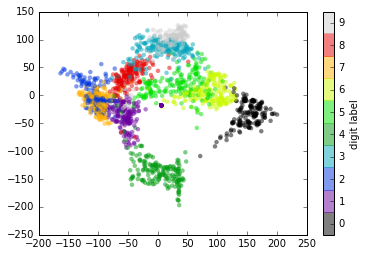

In [13]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
            edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10));
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5)

We see here that the digits are fairly well-separated in the parameter space; this tells us that a supervised classification algorithm should perform fairly well. Let's give it a try.

### Classification on Digits

Let's try a classification task on the digits. The first thing we'll want to do is split the digits into a training and testing sample:

In [14]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=2)
print(Xtrain.shape, Xtest.shape)

(1347, 64) (450, 64)


Let's use a simple logistic regression which (despite its confusing name) is a classification algorithm:

In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

We can check our classification accuracy by comparing the true values of the test set to the predictions:

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.94666666666666666

This single number doesn't tell us **where** we've gone wrong: one nice way to do this is to use the *confusion matrix*

In [17]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, ypred))

[[42  0  0  0  0  0  0  0  0  0]
 [ 0 45  0  1  0  0  0  0  3  1]
 [ 0  0 47  0  0  0  0  0  0  0]
 [ 0  0  0 42  0  2  0  3  1  0]
 [ 0  2  0  0 36  0  0  0  1  1]
 [ 0  0  0  0  0 52  0  0  0  0]
 [ 0  0  0  0  0  0 42  0  1  0]
 [ 0  0  0  0  0  0  0 48  1  0]
 [ 0  2  0  0  0  0  0  0 38  0]
 [ 0  0  0  1  0  1  0  1  2 34]]


/home/nbuser/anaconda3_410/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


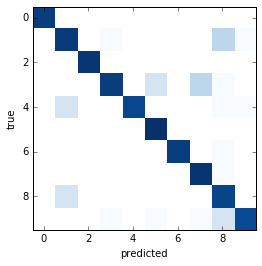

In [18]:
plt.imshow(np.log(confusion_matrix(ytest, ypred)), cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

We might also take a look at some of the outputs along with their predicted labels. We'll make the bad labels red:

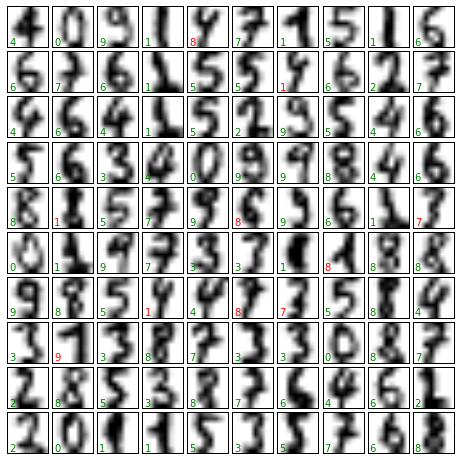

In [19]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(Xtest[i].reshape(8, 8), cmap='binary')
    ax.text(0.05, 0.05, str(ypred[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == ypred[i]) else 'red')
    ax.set_xticks([])
    ax.set_yticks([])

The interesting thing is that even with this simple logistic regression algorithm, many of the mislabeled cases are ones that we ourselves might get wrong!